In [1]:
import ipyparallel as parallel
client = parallel.Client(profile='default2')
view = client.load_balanced_view()
len(client.ids)

64

In [2]:
%%px
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
%%px --local
from ase.io import read
import numpy as np
from ase.units import fs, Ang

In [5]:
%%px --local

def water_cm(x):
    x = x.reshape(-1,3,3)
    return ((16*x[:,0] + x[:,1] + x[:,2])/18)

def get_t_corr(dt, path, lim):
    
    basepath = '/gpfs/scratch/smdick/'
    trajectories = read(basepath + path, lim)
    v = []
    all_v = []
    for i, traj in enumerate(trajectories[int(dt):]):
        v1 = traj.get_velocities()[0::3]
        all_v.append(np.mean(np.einsum('ij,ij -> i' , v1, v1)))
        v2 = trajectories[i].get_velocities()[0::3]
        v.append(np.mean(np.einsum('ij,ij -> i' , v1, v2)))
    return np.mean(v)/np.mean(all_v)


def get_t_corr_cm(dt, path, lim):
    
    basepath = '/gpfs/scratch/smdick/'
    trajectories = read(basepath + path, lim)
    v = []
    all_v = []
    for i, traj in enumerate(trajectories):
        trajectories[i].set_momenta(trajectories[i].get_momenta() -\
                                     np.mean(trajectories[i].get_momenta(), axis = 0))
        assert(np.allclose(np.sum(np.mean(trajectories[i].get_momenta(), axis = 0)), 0)) 
        
    for i, traj in enumerate(trajectories[int(dt):]):
        v1 = water_cm(traj.get_velocities())
        all_v.append(np.mean(np.einsum('ij,ij -> i' , v1, v1)))
        v2 = water_cm(trajectories[i].get_velocities())
        v.append(np.mean(np.einsum('ij,ij -> i' , v1, v2)))
    return np.mean(v)/np.mean(all_v)

def get_t_corr_vib(dt, path, lim):
    
    basepath = '/gpfs/scratch/smdick/'
    trajectories = read(basepath + path, lim)
    v = []
    all_v = []
#     for i, traj in enumerate(trajectories):
#         trajectories[i].set_momenta(trajectories[i].get_momenta() -\
#                                      np.mean(trajectories[i].get_momenta(), axis = 0))
#         assert(np.allclose(np.sum(np.mean(trajectories[i].get_momenta(), axis = 0)), 0))  
    for i, traj in enumerate(trajectories[int(dt):]):
        
        v1 = traj.get_velocities()[0::3]
        cm1 = water_cm(traj.get_velocities())
        v1 -= cm1
        all_v.append(np.mean(np.einsum('ij,ij -> i' , v1, v1)))
        v2 = trajectories[i].get_velocities()[0::3]
        cm2 = water_cm(trajectories[i].get_velocities())
        v2 -= cm2
        v.append(np.mean(np.einsum('ij,ij -> i' , v1, v2)))
    return np.mean(v)/np.mean(all_v)


In [15]:
# paths = ['mbpol/md_siesta_pure/md_siesta_10.traj',
#          'new/md_siesta_uftodz_5/md_siesta.traj',
#          'new/md_siesta_uftodz_8/md_siesta.traj',
#          'new/md_siesta_uftodz_10/md_siesta.traj',
#          'new/md_siesta_uftodz_inf/md_siesta.traj',
#          'mbpol/nose_128_10.traj']

# paths = ['mbpol/md_siesta_pure/md_siesta_10.traj',
#          'mbpol/md_siesta_mull/md_siesta.traj',
# #          'new/md_siesta_uftombp_5/md_siesta.traj',
# #          'new/md_siesta_uftodztombp_5/md_siesta.traj',
#          'new/md_siesta_uftodztombp_5_mol/md_siesta.traj',
#          'bugfix/md_siesta_uftodztombp_P_5/md_siesta.traj',
#          'bugfix/md_siesta_uftodztombp_pbc/md_siesta.traj',
#          'mbpol/nose_128_10.traj']

paths = ['mbpol/md_siesta_pure/md_siesta_10.traj',
         'new/md_siesta_uftombp_5/md_siesta.traj',
#          'new/md_siesta_uftombp_8/md_siesta.traj',
         'bugfix/md_siesta_uftodztombp_nomean_200/md_siesta.traj',
         'md_siesta_mull/md_siesta.traj',
#          'bugfix/md_siesta_uftodztombp_P_5/md_siesta.traj',
         'mbpol/nose_128_10.traj']

# limits = ['2000:4000:2']* len(paths)
limits = ['2000:6000:2']* len(paths)
v_corr_dict = {}

for path, lim in zip(paths, limits):
    name = path.split('/')[-2]
    dt = np.arange(0,200,1).astype(int)
    v_corr_dict[name] = view.map_sync(get_t_corr_vib, dt, [path]*len(dt), [lim]*len(dt))

# plot(v_corr)

In [16]:
labels = []
for path, lim in zip(paths, limits):
    name = path.split('/')[-2]
    labels.append(name)

0.07561631920838562
0.14508933816744685
0.12347429052074964
0.08130285570830224


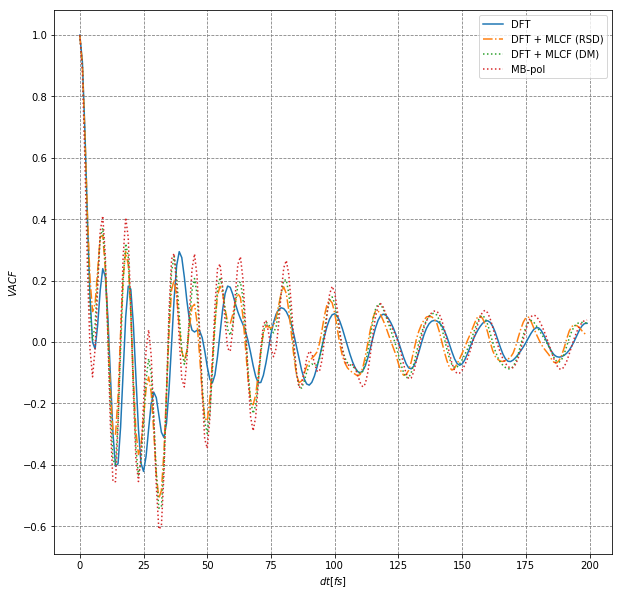

In [17]:
figsize(10,10)
skip = ['md_siesta_uftombp_15', 'md_siesta_uftombp_5',  'md_siesta_uftodztombp_P_5']
# skip = ['mbpol']
# skip = []
# labels = ['n = 1' , 'n = 5', 'n = 8', 'n = 10', 'n = $\infty$', 'MB-pol']
labels = ['DFT', 'skip', 'DFT + MLCF (RSD)', 'DFT + MLCF (DM)', 'MB-pol']
styles = ['-','--','-.',':',':', '-']
for key, name, style in zip(v_corr_dict,labels, styles):
    if key in skip: continue
    sum_ = np.sum(v_corr_dict[key])/(fs**2)/1000
    plot(v_corr_dict[key], label = name, ls = style )
    print(sum_)
ylabel('$VACF$')
xlabel('$dt [fs]$')
# xticks(range(0,201,25),range(0,401,50))
legend()
grid(color = 'grey', ls = '--')
savefig('../figs/vacf_dztombp_vib.eps', bbox_inches = 'tight')
savefig('../figs/vacf_dztombp_vib.pdf', bbox_inches = 'tight')

In [18]:
from scipy.fftpack import fft, fftshift

/gpfs/home/smdick/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


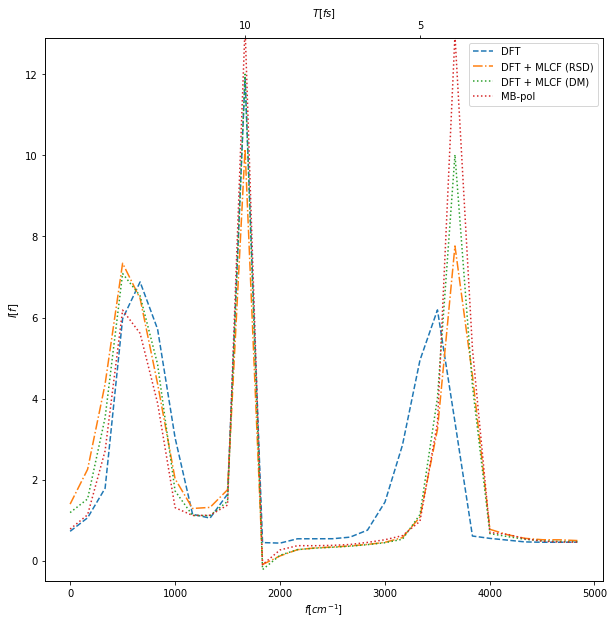

In [21]:
figsize(10,10)
skip = []
# skip = ['md_siesta_uftodz_10', 'mbpol']
# skip = ['mbpol']
# skip = ['md_siesta_uftodz_10']
# skip = ['md_siesta_uftodz_10','md_siesta_uftodz_5','md_siesta_uftodz_8','md_siesta_uftodz_inf','md_siesta_pure']
# labels = ['n = 1' , 'n = 5', 'n = 8', 'n = 10', 'n = $\infty$', 'MB-pol']
skip = ['md_siesta_uftombp_15', 'md_siesta_uftombp_5',  'md_siesta_uftodztombp_P_5']
styles = ['--','--','-.',':',':', '-']
# vlines(109.6,-2,13, color = 'red', linestyles = '--')
# vlines(112.6,-2,13, color = 'red')
# vlines(47.8,-2,13, color = 'red')
# vlines(20.5,-2,13, color = 'green')
# vlines(11.8,-2,13, color = 'green')
fig, ax = subplots()
for key, name, style in zip(v_corr_dict,labels, styles):
    if key in skip: continue
    ax.plot(np.arange(0,30)*5*33.36,fft(v_corr_dict[key])[0:30], label = name, ls = style )
    
ax2 = twiny()
# ax.vlines(3335.64095, 0,15)
# ax.vlines(1667.82048, 0, 15)
ax2.set_xticks(np.array([1767.82048,3335.6409])/5000 + 0.006)
ax2.set_xticklabels([10,5])
ax.set_ylabel('$I[f]$')
ax.set_xlabel('$f [cm^{-1}]$')
ax2.set_xlabel('$T[fs]$')
ax2.xaxis.set_ticks_position('top') # the rest is the same
ylim(-0.5,12.9)
# xticks(range(0,201,25),range(0,401,50))
ax.legend()
# grid(color = 'grey', ls = '--')

savefig('../figs/spectrum_dztombp_O.eps', bbox_inches = 'tight')
savefig('../figs/spectrum_dztombp_O.pdf', bbox_inches = 'tight')